In [1]:
import os
import time
import json

from utils.file_utils import *
from datasets import list_datasets
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from IPython import get_ipython
import pandas as pd
from tqdm import tqdm
from MergeModel import *
from ClassifierModel import *
import matplotlib.pyplot as plt

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', 2)

#### Bart tokenizer

In [2]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartForSequenceClassification

In [3]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [4]:
vocab_size = tokenizer.vocab_size
vocab_size

50265

### Classifier data

In [5]:
# from datasets import load_dataset

In [6]:
# dataset = load_dataset("imdb")

In [7]:
# train_batch = dataset['train']['text']
# train_labels = torch.tensor(dataset['train']['label'])

In [8]:
# train_batch = train_batch[:100]
# train_labels = torch.tensor(train_labels[:100])

In [9]:
# val_batch = dataset['test']['text']
# val_labels = torch.tensor(dataset['test']['label'])

In [10]:
# val_batch = val_batch[:100]
# val_labels = torch.tensor(val_labels[:100])

In [11]:
# seq_length = 150
# input_encoding = tokenizer(train_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [12]:
# val_encoding = tokenizer(val_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [13]:
# input_ids = input_encoding['input_ids']
# input_mask = input_encoding['attention_mask']

In [14]:
# val_ids = val_encoding['input_ids']
# val_mask = val_encoding['attention_mask']

In [15]:
# input_ids.shape, input_mask.shape, val_ids.shape, val_mask.shape

In [16]:
# # Creating DataLoaders

# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# # TRAINNG DATALOADER
# batch_size = 27

# train_data = TensorDataset(input_ids, input_mask, train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader_clf = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [17]:
# # VALIDATION DATALOADER

# val_data = TensorDataset(val_ids, val_mask, val_labels)
# val_sampler = RandomSampler(val_data)
# val_dataloader_clf = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [18]:
# b = next(iter(train_dataloader_clf))

In [19]:
# b[0].shape, b[1].shape, b[2].shape

##### end

#### BART Data

In [20]:
df = pd.read_csv("../BART/test.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 11,490



,article,highlights,id
7530,Nigel Farage is a 'Victor Meldrew in stilts' w...,EXCLUSIVE Nick Clegg warns the Ukip leader's '...,9dd4bb5194c7d35bea11c7af9c3711be4e9cd45d
3834,A morbidly obese man who piled on the pounds t...,"David Rush, 33, from Lisburn, Northern Ireland...",4255e0d77ddeb57e1bc7ff4f88d76fb494d88955
7805,Darren Bent has revealed an Aston Villa return...,Darren Bent currently on loan at Derby County ...,a4ef830316230a1ceb19ba427c9f1a407a82600c
9780,While David Cameron has long played up to his ...,Ukip leader posed for tradition campaign photo...,d4d57b23c4ecfa2a6c98412fc43d99ee4e5eee00
10693,Mad Men star Jon Hamm's secret college bullyin...,Mad Men star was charged with assault for Nove...,ec35ca922f2f717d417c685c3b5f5c7f64ca4867
5415,Scotland will definitely become independent on...,SNP leader says she is not planning second ref...,685573e9aaed8da47e163a983034505f7e3f90c6
7397,"World title-winning boxer, politician, actor, ...",Manny Pacquiao faces Floyd Mayweather in $300m...,9a953efc47ed0dd24bfd495e56c273f6d370aad6
6262,Alastair Cook insists he is 'refreshed' by thi...,England begin their tour of West Indies in Sai...,7dcf88724a7ac136386bda5df050e7ffc0267011
10316,"Don't be fooled, Arsene. Don’t be caught out b...",It is not unusual to see Arsenal finish the se...,e314cc9a7bb35fe8cfdbb4b9af410d65e2215bdf
4431,Hector Bellerin has enjoyed a superb breakthro...,Hector Bellerin claims 12 per cent of the vote...,515f236744a7af8167c5cb8f2ae3a2f5997b6ece


In [21]:
train_sentence = df.article.values
train_target = df.highlights.values

In [22]:
num_data_points = 100
train_sentence = list(train_sentence[:num_data_points])
train_target = list(train_target[:num_data_points])

In [23]:
article_encoding = tokenizer(train_sentence, return_tensors='pt', padding=True, truncation = True, max_length=500)
summary_encoding = tokenizer(train_target, return_tensors='pt', padding=True,truncation = True, max_length=100)

In [24]:
article_input_ids = article_encoding['input_ids']
article_attention_mask = article_encoding['attention_mask']

In [25]:
summary_input_ids = summary_encoding['input_ids']
summary_attention_mask = summary_encoding['attention_mask']

In [26]:
print(article_input_ids.shape, article_attention_mask.shape)

torch.Size([100, 500]) torch.Size([100, 500])


In [27]:
print(summary_input_ids.shape, summary_attention_mask.shape)

torch.Size([100, 72]) torch.Size([100, 72])


In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [29]:
batch_size = 4
train_data = TensorDataset(article_input_ids, article_attention_mask,\
                           summary_input_ids, summary_attention_mask)

In [30]:
train_sampler = RandomSampler(train_data)

In [31]:
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [32]:
def loss_fn(lm_logits, labels):
    loss_fct = CrossEntropyLoss(ignore_index = tokenizer.pad_token_id)
    loss = loss_fct(lm_logits.view(-1, vocab_size), labels.view(-1))
    return loss

In [33]:
mse_loss = nn.MSELoss()

In [34]:
sent_model = ClassifierModel(vocab_size, 64, 2, 2, 512).cuda()

sent_model.load_state_dict(torch.load('classifier_model.pt'))

<All keys matched successfully>

In [35]:
for params in sent_model.parameters():
    params.requires_grad = False

In [36]:
summary_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [37]:
summary_model = summary_model.cuda()
senti_model = sent_model.cuda()

In [38]:
# embedding_dim = 64
# out_dim = 2
# n_layers = 4
# hidden_size = 512
merge_model = MergeModel(summary_model, senti_model).cuda()
model_name = 'BART_classifier'
model_dir = './experiment'
model_path = os.path.join(model_dir,model_name)
epochs  = 100

In [39]:
for params in merge_model.sentiment_model.parameters():
    params.requires_grad = False

In [40]:
config = {
#     'embedding_dim': embedding_dim,
#     'out_dim': out_dim,
#     'n_layers': n_layers,
#     'hidden_size': hidden_size,
    'model_name': model_name,
    'epochs':epochs
}

In [41]:
# Apply the weighting lambdas in the main function this is just a loss without lambda weights
def kl_div_loss(p_pred, p_target):
    
    softmax = nn.Softmax(dim=-1)
    
    logsoftmax = nn.LogSoftmax(dim=-1)
    
    kl_div = torch.nn.KLDivLoss()
    
    return kl_div(logsoftmax(p_pred),softmax(p_target))

In [42]:
softmax = nn.Softmax(dim=-1)
cross_entropy = torch.nn.CrossEntropyLoss()

In [49]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, model_dir='/experiment',config = None):
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    min_val_loss = np.inf
    
    model_name = config['model_name']
    print(f"Start training for Model {model_name}...\n")
    
    
#     if not os.path.exists(os.path.join(model_dir,model_name)):
#         os.mkdir(os.path.join(model_dir,model_name))
#     model_path = os.path.join(model_dir,model_name)
#     print(model_path)
#     write_to_file_in_dir(model_path, 'config.json', config)
    
#     train_log =  'train_log.txt'
#     write_string_train = f"Epoch, Train_Loss, Train_Acc"
#     log_to_file_in_dir(model_path, train_log, write_string_train)

#     if evaluation:
#         val_log = 'val_log.txt'
#         write_string_val = f"Epoch, Val_Loss, Val_Acc"
#         log_to_file_in_dir(model_path, val_log, write_string_val)
    
    from transformers import AdamW
    bart_optimizer = AdamW(model.parameters(), lr=1e-5)
    
    sentiment_optimizer = torch.optim.SGD(model.parameters(),1e-5,momentum=0.9,weight_decay=0.01)
    
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Loss 1':^12} | {'Loss 2':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_loss1, batch_loss2, batch_counts = 0, 0, 0, 0, 0
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            model.train()
            batch_counts +=1
            
            batch[0] = batch[0].cuda()
            batch[1] = batch[1].cuda()
            batch[2] = batch[2].cuda()
            batch[3] = batch[3].cuda()
            
            bart_optimizer.zero_grad()
            sentiment_optimizer.zero_grad()
            
            summary_out,*sentiments = model(batch[0],batch[1], batch[2], batch[3])
        
            cost1, cost2 = 2, 1e-1
            
            loss1 = cost1*loss_fn(summary_out.logits, batch[2])

            
            loss2 = cost2*kl_div_loss(sentiments[0], sentiments[1])
            # loss2 = cost2*mse_loss(softmax(sentiments[0]), softmax(sentiments[1]))
            

            loss = loss1 + cost2 * loss2
            
            batch_loss += loss.item()
            
            batch_loss1 += loss1.item()
            
            batch_loss2 += loss2.item()
            
            total_loss += loss.item()
            
            train_losses.append(loss.item())
            
#             print(torch.autograd.grad(loss2, merge_model.summary_model.parameters(),retain_graph = True)[0])

#             write_string_train = f"{epoch_i}, {loss.item()}"
#             log_to_file_in_dir(model_path, train_log, write_string_train)
            
            
            loss1.backward(retain_graph = True)
            
            loss2.backward()
            
            bart_optimizer.step()
            
            sentiment_optimizer.step()
            
            if (step % 10 == 0) and (step != 0):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_loss1 / batch_counts:^12.6f} | {batch_loss2 / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_loss1, batch_loss2, batch_counts = 0, 0, 0, 0
                t0_batch = time.time()
                
                print("-"*70)


        
        if ((epoch_i %5 ==0) and (epoch_i != 0)) or (epoch_i==epochs-1):
            
            print([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_out.logits.argmax(dim = -1)])
        
            
        
    torch.save(model.state_dict(), 'BART_classifier_final.pt')
        
    return  train_losses, train_accs, val_losses,val_accs

In [53]:
# stats = train(merge_model, train_dataloader, val_dataloader=None, epochs=epochs, evaluation=False,  config=config)

In [45]:
train_losses, train_accs, val_losses,val_accs = stats

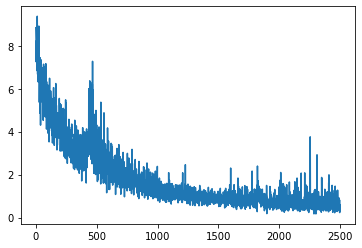

In [46]:
plt.plot(np.arange(len(train_losses)), np.array(train_losses))

# Testing

b1,b2,b3,b4 = next(iter(train_dataloader))
b1 = b1.cuda()
b2 = b2.cuda()
b3 = b3.cuda()
b4 = b4.cuda()

b1.shape, b2.shape, b3.shape, b4.shape

z1 = torch.nn.Parameter(torch.ones_like(b1).float()).long()
z2 = torch.ones_like(b2)

z1_dash = z1 + 5
z2_dash = z2 + 5

t = summary_model(b1, b2)

t.logits.shape

merge_model.train()

t_dash = merge_model(b1, b2, b3,b4)

t_dash[0].logits.shape

loss = mse_loss(t_dash[1], t_dash[2])

print(torch.autograd.grad(loss,merge_model.summary_model.parameters(), retain_graph=True))